In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import itertools

#### Load Data Set


In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Assignment 5 Dataset'

In [0]:
#!unzip "/content/drive/My Drive/Assignment 5 Dataset.zip" -d "/content/drive/My Drive"
#data_dir = '/content/drive/My Drive/Assignment 5 Dataset'

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       #transforms.RandomResizedCrop(224),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [10]:
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/test', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)



Classes: 
['infected', 'normal']


In [11]:
len(train_data)

10717

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


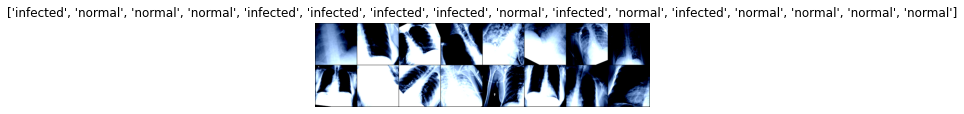

In [12]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(validloader))
show_databatch(inputs, classes)

## **Task 1**

#### Load pretrained models

In [0]:
# Load the pretrained model from pytorch

# Load VGG 16
#vgg16 = models.vgg16(pretrained=True)
vgg16 = models.vgg16(pretrained = False)
# Load ResNet16
#resnet = models.resnet18(pretrained= True)
resnet = models.resnet18(pretrained = False)


### Fine Tuning on VGG16

In [14]:
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
print(vgg16.classifier[3])

Linear(in_features=4096, out_features=4096, bias=True)


 #### Freezing all the layers except last FC layers

Remove all FC layers and add new one


In [16]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)
print(num_features)

[]
25088


In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
# adding new features

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(num_features, 460 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),
     nn.Linear(460 ,len(class_names))])

In [19]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Load pre trained model


In [33]:
# if you have already trained model then use this to load
vgg16.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/vgg16_FC_Only.pth'))
vgg16.cuda() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Training on VGG 16

In [0]:
# Loss fucntion and optimizer
Epochs = 12
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

losses=[]
n = len(train_data)

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

      
        optimizer.zero_grad()
    
        outputs = vgg16(inputs)             #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    losses.append( running_loss/len(trainloader))    
    torch.save(vgg16.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [3440/10283 (99%)]	Loss: 0.116779: : 81it [2:38:37, 117.49s/it]
Train Epoch: 1 [3440/10283 (99%)]	Loss: 0.222916: : 81it [12:25,  9.20s/it]
Train Epoch: 2 [3440/10283 (99%)]	Loss: 0.122923: : 81it [12:10,  9.01s/it]
Train Epoch: 3 [3440/10283 (99%)]	Loss: 0.063769: : 81it [12:15,  9.08s/it]
Train Epoch: 4 [3440/10283 (99%)]	Loss: 0.089456: : 81it [12:14,  9.07s/it]
Train Epoch: 5 [3440/10283 (99%)]	Loss: 0.146678: : 81it [12:14,  9.06s/it]
Train Epoch: 6 [3440/10283 (99%)]	Loss: 0.055191: : 81it [12:08,  9.00s/it]
Train Epoch: 7 [3440/10283 (99%)]	Loss: 0.063663: : 81it [11:59,  8.88s/it]
Train Epoch: 8 [3440/10283 (99%)]	Loss: 0.178832: : 81it [11:59,  8.88s/it]
Train Epoch: 9 [3440/10283 (99%)]	Loss: 0.178556: : 81it [11:58,  8.87s/it]
Train Epoch: 10 [3440/10283 (99%)]	Loss: 0.029856: : 81it [11:58,  8.87s/it]
Train Epoch: 11 [3440/10283 (99%)]	Loss: 0.008375: : 81it [11:55,  8.83s/it]


Finished Training


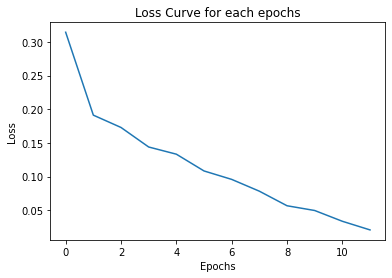

In [28]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses)

#### **Testing**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


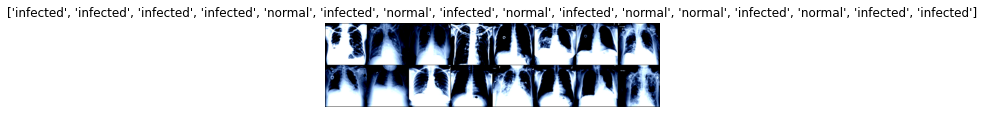

In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

#### Accuracy

**Testing Accuracy**

In [0]:
def Accuracy(network ,dataset):
  correct = 0
  total = 0
  inx = 0 
  predlist=torch.zeros(0,dtype=torch.long, device='cuda')
  lbllist=torch.zeros(0,dtype=torch.long, device='cuda')
  with torch.no_grad():
    for data in dataset:

        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)

        predlist=torch.cat([predlist,predicted.view(-1)])
        lbllist=torch.cat([lbllist,labels.view(-1)])

        inx += 1
        print("\r Iterating on image batches : ",inx,end="")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  return (100*correct/total),predlist,lbllist

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
t_acc , pr, lb = Accuracy(vgg16,testloader)
print("\n Testing Accuracy %d %%" % t_acc)

 Iterating on image batches :  94
 Testing Accuracy 91 %


In [34]:
t_acc , pr, lb = Accuracy(vgg16,testloader)
print("\n Testing Accuracy %d %%" % t_acc)

 Iterating on image batches :  94
 Testing Accuracy 91 %


Confusion matrix, without normalization
[[546  69]
 [ 64 821]]


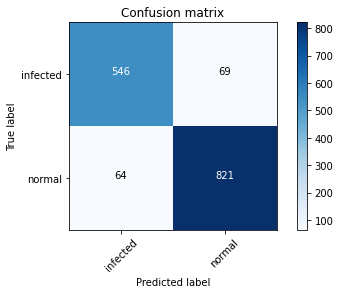

In [36]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

**Validation Accuracy & Confusion Matrix**

In [38]:
acc, pred, lbls = Accuracy(vgg16,validloader)
print('\nAccuracy of the network on the Validation images: %d %%' % acc)

 Iterating on image batches :  94
Accuracy of the network on the Validation images: 64 %


Confusion matrix, without normalization
[[601  14]
 [513 372]]


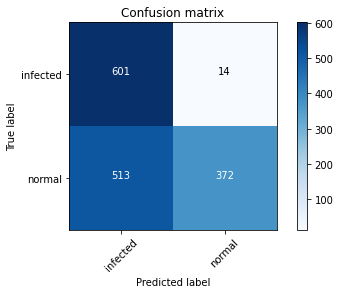

In [39]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

**Training Accuracy & Confusion Matrix**

In [41]:
acc, pred, lbls = Accuracy(vgg16,trainloader)
print('\n [ Training Accuracy ] : %d %%' % acc)

 Iterating on image batches :  81
 [ Training Accuracy ] : 99 %


Confusion matrix, without normalization
[[4585   35]
 [   2 5661]]


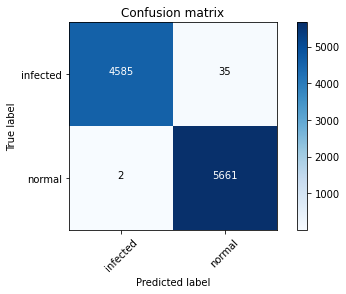

In [42]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected normal
Predicted:  infected infected


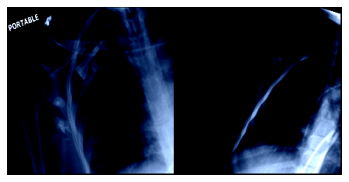

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
images,labels = images[:2],labels[:2]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

In [0]:
dataiter = iter(tesloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected normal
Predicted:  infected infected


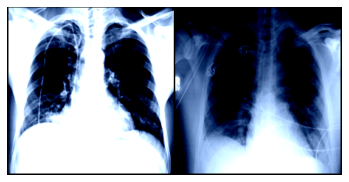

In [0]:
images,labels = images[:2],labels[:2]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

### Fine Tuning on Resnet

In [28]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
nfeatures = resnet.fc.in_features

features = list(resnet.fc.children())[:-1] #Remove last layer
print(features)

[]


In [0]:
# Freeze training for all layers
for param in resnet.parameters():
    param.require_grad = False

In [0]:
# adding new features

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(nfeatures, 460 ),
     nn.ReLU(inplace=True),
     nn.Linear(460 ,len(class_names))])

In [32]:
resnet.fc = nn.Sequential(*features)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training on Resnet

In [35]:
resnet.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/res18_FC_Only.pth'))
resnet.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Loss fucntion and optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [50]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

resnet.train()

n = len(train_data)
losses_r = []
acc_r = []
correct = 0

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
    
        outputs = resnet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_r.append(100 * correct / n) 
    losses_r.append(running_loss/len(trainloader))
        
    torch.save(resnet.state_dict(), '/content/drive/My Drive/Colab Notebooks/res18_FC_Only.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/10283 (0%)]	Loss: 0.682311: : 0it [00:03, ?it/s]
Train Epoch: 0 [0/10283 (0%)]	Loss: 0.682311: : 1it [00:03,  3.75s/it]
Train Epoch: 0 [128/10283 (1%)]	Loss: 0.664548: : 1it [00:07,  3.75s/it]
Train Epoch: 0 [128/10283 (1%)]	Loss: 0.664548: : 2it [00:07,  3.79s/it]
Train Epoch: 0 [256/10283 (2%)]	Loss: 0.676973: : 2it [00:11,  3.79s/it]
Train Epoch: 0 [256/10283 (2%)]	Loss: 0.676973: : 3it [00:11,  3.79s/it]
Train Epoch: 0 [384/10283 (4%)]	Loss: 0.673654: : 3it [00:15,  3.79s/it]
Train Epoch: 0 [384/10283 (4%)]	Loss: 0.673654: : 4it [00:15,  3.78s/it]
Train Epoch: 0 [512/10283 (5%)]	Loss: 0.661834: : 4it [00:18,  3.78s/it]
Train Epoch: 0 [512/10283 (5%)]	Loss: 0.661834: : 5it [00:18,  3.76s/it]
Train Epoch: 0 [640/10283 (6%)]	Loss: 0.646795: : 5it [00:22,  3.76s/it]
Train Epoch: 0 [640/10283 (6%)]	Loss: 0.646795: : 6it [00:22,  3.83s/it]
Train Epoch: 0 [768/10283 (7%)]	Loss: 0.645344: : 6it [00:26,  3.83s/it]
Train Epoch: 0 [768/10283 (7%)]	Loss: 0

Finished Training


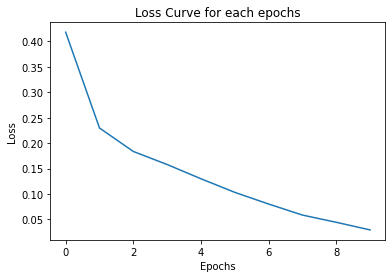

In [51]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses_r)

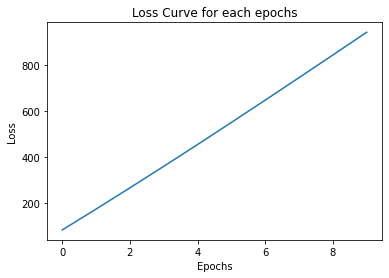

In [52]:
plt.title("Accuracy for each epochs")
plt.plot(acc_r)

#### Testing [Resnet]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected normal infected normal
Predicted:  infected normal infected normal


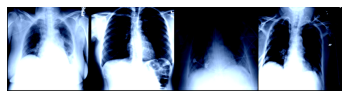

In [37]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:4],labels[:4]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

#### Accuracy (of model trained on ResNet)

**Training Accuracy and Confusion Matrix**

In [0]:
acc, pred, lbls = Accuracy(resnet,trainloader)
print('\n [ Training Accuracy ] : %d %%' % acc)

 Iterating on image batches :  145
 [ Training Accuracy ] : 91 %


Confusion matrix, without normalization
[[3560  519]
 [ 271 4929]]


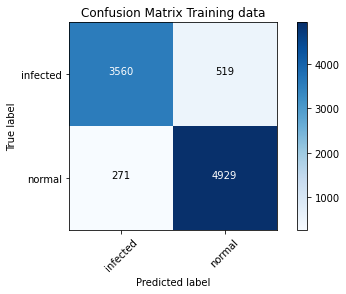

In [0]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Training data")

**Testing Accuracy and Confusion Matrix**

In [0]:
ac, p, lb = Accuracy(resnet,testloader)
print('\n [ Testing Accuracy ] : %d %%' % ac)

 Iterating on image batches :  94
 [ Testing Accuracy ] : 87 %


Confusion matrix, without normalization
[[511 104]
 [ 97 788]]


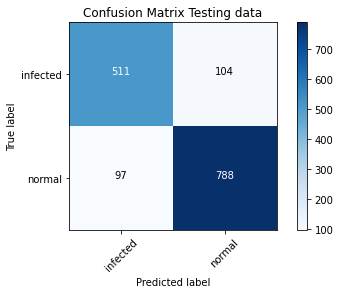

In [0]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), p.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Testing data")

**Validation Accuracy and Confusion Matrix**

In [0]:
ac, pr, lb = Accuracy(resnet,validloader)
print('\n [ Validation Accuracy ] : %d %%' % ac)


 [ Validation Accuracy ] : 81 %


Confusion matrix, without normalization
[[510 105]
 [176 709]]


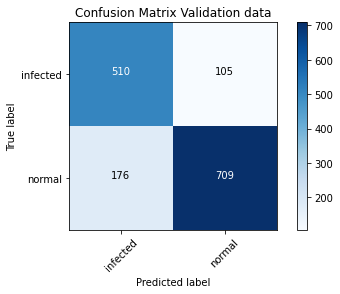

In [0]:
# confusion matrix for validation data 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Validation data")

*Testing*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  normal infected
Predicted:  normal infected


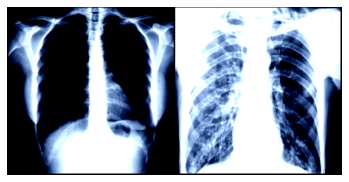

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:2],labels[:2]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

## **Task 2** 

For task 2 we are again loading pretrained model of VGG 16 and Resnet 18

In [39]:
# Load the pretrained model from pytorch

# Load VGG 16
VGG = models.vgg16(pretrained=True)
# Load ResNet16
RESNET = models.resnet18(pretrained= True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
#print(VGG)

In [0]:
# Freeze training for all layers except last 5
for param in VGG.features[:25].parameters():
    param.requires_grad = False

In [57]:
num_features = VGG.classifier[0].in_features

# update FC Layer new features
features = list(VGG.classifier.children())[:-7] 
print(features)
print(num_features)

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(num_features, 460 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),
     nn.Linear(460 ,len(class_names))])

[]
25088


In [58]:
VGG.classifier = nn.Sequential(*features)
print(VGG)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Loss fucntion and optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

VGG.train()

n = len(train_data)
loss_VGG = []
acc_VGG = []
correct = 0

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
    
        outputs = resnet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_VGG.append(100 * correct / n) 
    loss_VGG.append(running_loss/len(trainloader))
        
    torch.save(resnet.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_Few_Only_1.pth')

print('Finished Training')

Train Epoch: 0 [1152/10717 (11%)]	Loss: 0.023953: : 10it [17:09, 102.28s/it]